[-11.48755054 -10.3745611   -9.855693    -9.45307732  -9.29706776
  -9.15760449]
[-11.48755054 -10.3745611   -9.855693    -9.45307732  -9.29706776
  -9.15760449]
[-16.04971755 -15.34651282 -15.06170858 -14.93020587 -14.59635395
 -14.35963302]
[-16.04971755 -15.34651282 -15.06170858 -14.93020587 -14.59635395
 -14.35963302]
[-25.7374429  -25.24380336 -24.70007512 -24.58343179 -24.2392692
 -24.07811306]
[-25.7374429  -25.24380336 -24.70007512 -24.58343179 -24.2392692
 -24.07811306]
[-36.16768094 -35.69685845 -35.48937983 -35.42319915 -35.20262465
 -34.79951262]
[-36.16768094 -35.69685845 -35.48937983 -35.42319915 -35.20262465
 -34.79951262]
[-44.64968158 -44.34390578 -43.96386802 -43.86682632 -43.64437014
 -43.40552322]
[-44.64968158 -44.34390578 -43.96386802 -43.86682632 -43.64437014
 -43.40552322]
[-51.12320722 -50.95998482 -50.85675908 -50.73360136 -50.48107051
 -50.15595849]
[-51.12320722 -50.95998482 -50.85675908 -50.73360136 -50.48107051
 -50.15595849]
[-57.40057754 -57.07285509 -56

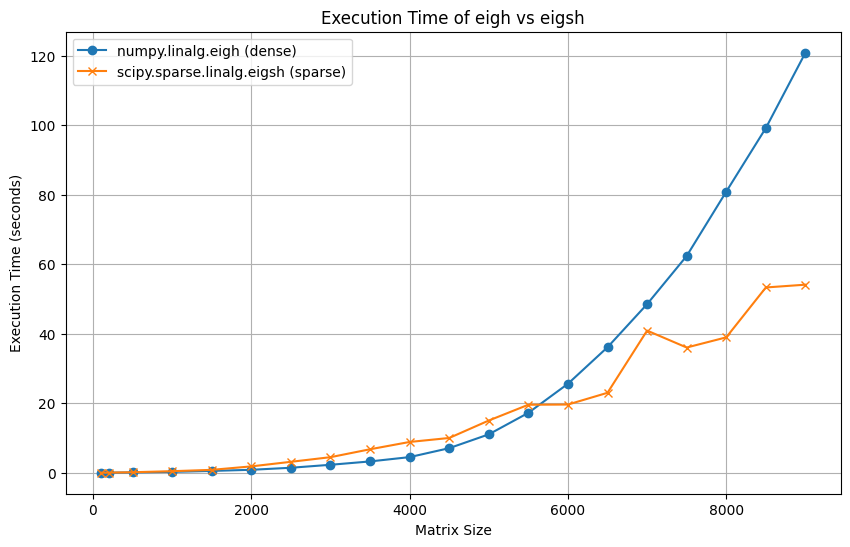

In [9]:
import numpy as np
import scipy.sparse as sp
from scipy.sparse.linalg import eigsh
from numpy.linalg import eigh
import time
import matplotlib.pyplot as plt

# Adjusting matrix sizes for the benchmark with a smaller maximum size
matrix_sizes = [100, 200, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500, 8000, 8500, 9000]

# Re-initialize lists to hold execution times
times_eigh = []
times_eigsh = []

for size in matrix_sizes:
    # Generate a random dense Hermitian matrix
    A_dense = np.random.rand(size, size) + 1j * np.random.rand(size, size)
    A_dense = A_dense + A_dense.conj().T  # Making it Hermitian
    
    # Convert the dense matrix to a sparse format (CSR)
    A_sparse = sp.csr_matrix(A_dense)
    
    # Time numpy's eigh (dense)
    start_time = time.perf_counter()
    eigenvalues, eigenvectors = eigh(A_dense)
    e = time.perf_counter() - start_time
    times_eigh.append(e)
    print(eigenvalues[:6])
    
    # Time scipy's eigsh (sparse)
    start_time = time.perf_counter()
    eigenvalues, eigenvectors = eigsh(A_sparse, k=6, which='SA')  # Asking for 6 eigenvalues
    e = time.perf_counter() - start_time
    times_eigsh.append(e)
    print(eigenvalues[:6])

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(matrix_sizes, times_eigh, label='numpy.linalg.eigh (dense)', marker='o')
plt.plot(matrix_sizes, times_eigsh, label='scipy.sparse.linalg.eigsh (sparse)', marker='x')
plt.xlabel('Matrix Size')
plt.ylabel('Execution Time (seconds)')
plt.title('Execution Time of eigh vs eigsh')
plt.legend()
plt.grid(True)
plt.show()


In [11]:
import cupy as cp
import time
import numpy as np

def perform_task(data, w, v):
    # Example task (eigendecomposition)
    w, v = cp.linalg.eigh(data)

# Create random data for the task (replace with your actual data)
N = 10000  # Number of tasks
size = 256
data = [cp.random.rand(size, size) for _ in range(N)]  # List of matrices
# data_eigh = cp.random.rand(N, size, size)
# data_eigh_cpu = np.random.rand(N, size, size)
w = cp.empty((size,), cp.float64)
v = cp.empty((size,size), cp.float64)

In [2]:
def eigh_batch(data_eigh):

    start_time = time.time()

    w, v = cp.linalg.eigh(data_eigh)

    elapsed_time = time.time() - start_time
    print(f"time: {elapsed_time} s")

In [5]:
def eigh_batch_cpu(data_eigh):

    start_time = time.time()

    w, v = np.linalg.eigh(data_eigh)

    elapsed_time = time.time() - start_time
    print(f"time: {elapsed_time} s")

In [13]:
def find_optimal_streams(data, w, v, max_streams=100):
    optimal_streams = 1
    min_time = float('inf')

    for num_streams in range(1, max_streams + 1):
        streams = [cp.cuda.Stream(non_blocking=True) for _ in range(num_streams)]
        start_time = time.time()

        # Assign tasks to streams and execute
        for i, d in enumerate(data):
            with streams[i % num_streams]:
                perform_task(d, w, v)  # Perform your task

        # Synchronize all streams
        for stream in streams:
            stream.synchronize()

        elapsed_time = time.time() - start_time
        print(f"Streams:{num_streams} - time: {elapsed_time} s")

        # Update optimal number of streams if current configuration is better
        if elapsed_time < min_time:
            min_time = elapsed_time
            optimal_streams = num_streams

    return optimal_streams


In [14]:
# data = [cp.random.rand(size, size) for _ in range(N)]  # List of matrices
find_optimal_streams(data, w, v)

Streams:10000 - time: 25.395099639892578 s


10000

In [3]:
# data_eigh = cp.random.rand(N, size, size)
# data_eigh = cp.random.rand(size, size)
eigh_batch(data_eigh)

time: 121.74850869178772 s


In [6]:
# data_eigh_cpu = np.random.rand(size, size)
eigh_batch_cpu(data_eigh_cpu)

time: 63.54161262512207 s


In [6]:
import numpy as np
from numba import jit, cuda, float64
import math
import time
KB = 1. # Boltzmann constant
dim = 700000000
energies = np.random.rand(dim)
energies = energies - energies[0]
states_momenta = np.random.rand(dim)
temperatures = np.linspace(1,300,300)

In [7]:
@jit(
    "float64(float64[:], float64[:], float64)",
    nopython=True,
    nogil=True,
    cache=True,
    fastmath=True,
)
def _calculate_magnetization(
    energies: np.ndarray, states_momenta: np.ndarray, temperature: np.float64
) -> np.float64:
    states_momenta = np.ascontiguousarray(states_momenta)
    # Boltzman weights
    exp_diff = np.ascontiguousarray(np.exp(-(energies)))
    # Partition function
    z = np.sum(exp_diff)

    # Weighted magnetic moments of microstates
    m = np.vdot(states_momenta, exp_diff)
    # m = np.sum(states_momenta * exp_diff)

    return m / z

start = time.perf_counter()
result = _calculate_magnetization(energies, states_momenta, temperatures[0])
stop = time.perf_counter()
print(f"Execution time: {stop - start} s")
print(result)

Execution time: 5.27120435499819 s
0.49999637044398343


In [4]:
import cupy as cp
from cupyx.profiler import benchmark
from cupyx import optimizing


mempool = cp.get_default_memory_pool()
pinned_mempool = cp.get_default_pinned_memory_pool()
mempool.free_all_blocks()
pinned_mempool.free_all_blocks()

def _calculate_magnetization(
    energies: np.ndarray, states_momenta: np.ndarray, temperature: np.float64
) -> np.float64:

    with optimizing.optimize():
    
        energies = cp.array(energies)
        states_momenta = cp.array(states_momenta)
        
        states_momenta = cp.ascontiguousarray(states_momenta)
        energies = cp.ascontiguousarray(-energies)
        # Boltzman weights
        cp.exp(energies, out=energies)
        
        # Partition function
        z = cp.sum(energies)
    
        # Weighted magnetic moments of microstates
        m = cp.vdot(states_momenta, energies)
        # m = np.sum(states_momenta * exp_diff)

    return m / z

start = time.perf_counter()
result = _calculate_magnetization(energies, states_momenta, temperatures[0])
stop = time.perf_counter()
print(f"Execution time: {stop - start} s")
print(result)
print(benchmark(_calculate_magnetization, (energies, states_momenta, temperatures[0]), n_repeat=10))

Execution time: 4.469990958998096 s
0.5000024046795727
_calculate_magnetization:    CPU: 495245.952 us   +/- 3320.781 (min: 491161.499 / max: 500038.903) us     GPU-0: 797562.653 us   +/- 7443.771 (min: 788338.501 / max: 808944.641) us


In [8]:
# energies = energies.astype(np.float32)
# states_momenta = states_momenta.astype(np.float32)
@cuda.reduce
def sum_reduce(a,b):
    return a + b

@cuda.jit(cache=True)
def calculate_exp_diff_momenta_kernel(energies, states_momenta, exp_diff):
    i = cuda.grid(1)  # 1D grid
    if i < energies.shape[0]:
        exp_diff[i] = math.exp(-(energies[i]))
        states_momenta[i] *= exp_diff[i]

start = time.perf_counter()
start_event = cuda.event(timing=True)
end_event = cuda.event(timing=True)

exp_diff = cuda.device_array_like(energies)
energies = cuda.to_device(energies)
states_momenta = cuda.to_device(states_momenta)

threads_per_block = 1024 # This should be a power of 2
blocks_per_grid = math.ceil(energies.shape[0] / threads_per_block)

start_event.record()  # Record the start event

# Calculate exp_diff array
calculate_exp_diff_momenta_kernel[blocks_per_grid, threads_per_block](energies, states_momenta, exp_diff)

z = sum_reduce(exp_diff)
m = sum_reduce(states_momenta)

end_event.record()  # Record the end event
end_event.synchronize()  # Wait for the event to be executed!

# Calculate the time difference between start and end events
time_diff = cuda.event_elapsed_time(start_event, end_event)

cuda.synchronize()
stop = time.perf_counter()

print("Kernel execution time: ", time_diff, "milliseconds")
print(f"Execution time: {stop - start} s")

c= m/z
print(c-result)

/home/mikolaj/VIRTUAL/ENV1/lib/python3.11/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 64 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Kernel execution time:  401.0675964355469 milliseconds
Execution time: 1.1104696679976769 s
8.343326030058051e-14


/home/mikolaj/VIRTUAL/ENV1/lib/python3.11/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


0.9601920331435132

-0.04062198000000006